In [3]:
# For DL modeling
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn

# For number-crunching
import numpy as np
import scipy.stats as stats

# For dataset management
import pandas as pd
from sklearn.model_selection import train_test_split

# For data visualization
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
import seaborn as sns

# For timing computations
import time

import copy

import sklearn.metrics as skm

C:\Users\DOANTR~1\AppData\Local\Temp/ipykernel_13908/4004001396.py:18: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Import and process the data

In [4]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=';')
# Remove rows with outliers
data = data[data['total sulfur dioxide']<200]

# Z-SCORE ALL VARIABLES EXCEPT FOR QUALITY
# Find the columns we want to normalize (all except quality)
cols_2_zscore = data.keys()
cols_2_zscore = cols_2_zscore.drop('quality')
data[cols_2_zscore] = data[cols_2_zscore].apply(stats.zscore)

qual_threshold = 5
# Create a new column for binarized (boolean) quality
temp = (data['quality'] > qual_threshold).astype(int)
data['boolQuality'] = temp

# Convert from pandas dataframe to tensor
dataT  = torch.tensor(data=data[cols_2_zscore].values).float()
labels = torch.tensor(data=data['boolQuality'].values).float()
labels = labels[:, None] # Transform to matrix. We'll actually need the labels to be a "tensor"

#  Use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = \
    train_test_split(dataT, labels, test_size=0.1)

# Convert into PyTorch Datasets
train_data_set = TensorDataset(train_data, train_labels)
test_data_set  = TensorDataset(test_data, test_labels)

# Translate into Dataloader objects
batch_size   = 32
train_loader = DataLoader(dataset=train_data_set, batch_size=batch_size,
                          shuffle=True, drop_last=True)
test_loader  = DataLoader(dataset=test_data_set, 
                          batch_size=test_data_set.tensors[0].shape[0])

# Now for the DL part

In [5]:
class ANN_wine(nn.Module):
  """
  DATA_ UNBALANCED DATA | WEIGHTS_ XAVIER_VS._KAIMING
  """
  def __init__(self):
    super().__init__()

    # LAYERS
    # Input layer
    self.input = nn.Linear(11, 16)

    # Hidden layer(s). 'fc' = fully connected
    self.fc1 = nn.Linear(16, 32)
    self.fc2 = nn.Linear(32, 32)

    # Output layer
    self.output = nn.Linear(32, 1)
  
  # Forward pass
  def forward(self, x):
    x = F.leaky_relu(self.input(x))
    x = F.leaky_relu(self.fc1(x))
    x = F.leaky_relu(self.fc2(x))

    return self.output(x)

# A function to train the model

In [6]:
# Global parameter
num_epochs = 600

def train_the_model(wine_net):
  """
  WEIGHTS_ XAVIER_VS._KAIMING
  """

  loss_func = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(wine_net.parameters(), lr=0.01)

  # Initialize accuracies as empties
  train_acc = []
  test_acc  = []
  losses = torch.zeros(num_epochs)

  # Loop over epochs
  for epoch_i in range(num_epochs):
    # Activate training mode
    wine_net.train()

    # Loop over training data batches
    batch_acc = []
    batch_loss = []

    for X, y in train_loader:

      # Forward pass and loss
      y_hat = wine_net(X)
      loss  = loss_func(y_hat, y)

      # Backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Compute training accuracy just for this batch
      batch_acc.append(100 * torch.mean(((y_hat > 0) == y).float()).item())

      # Loss from this batch
      batch_loss.append(loss.item())

    # End of batch loop...

    # Now that we've trained through the batches, get their average training accuracy 
    train_acc.append(np.mean(batch_acc))

    # Get average losses across the batches
    losses[epoch_i] = np.mean(batch_loss)

    # Test accuracy (NOTE: testing in batches!)    
    X, y = next(iter(test_loader))  # Extract x,y from test dataloader
    wine_net.eval()                 # Activate testing mode
    with torch.no_grad():           # Deactivates autograd
      # pred_labels = torch.argmax(wine_net(X), axis=1)
      pred_labels = wine_net(X)

    # Compute accuracy
    test_acc.append(100 * torch.mean(((pred_labels > 0) == y).float()).item())

  # Function output
  return train_acc, test_acc, losses

# Experiment: initialize weights and test model!

In [8]:
# Create a model
wine_net_xavier = ANN_wine()

# Change the weights (leave biases as Kaiming [default])
for p in wine_net_xavier.named_parameters():
    if ('weight' in p[0]):
        nn.init.xavier_normal_(p[1].data)

# Train the model and record its output
train_acc_X, test_acc_X, losses_X = train_the_model(wine_net=wine_net_xavier)

#==========================================

# Create a model
wine_net_kaiming = ANN_wine()

# Change the weights (leave biases as Kaiming [default])
for p in wine_net_kaiming.named_parameters():
    if ('weight' in p[0]):
        nn.init.kaiming_uniform_(p[1].data, nonlinearity='relu')

# Train the model and record its output
train_acc_K, test_acc_K, losses_K = train_the_model(wine_net=wine_net_kaiming)

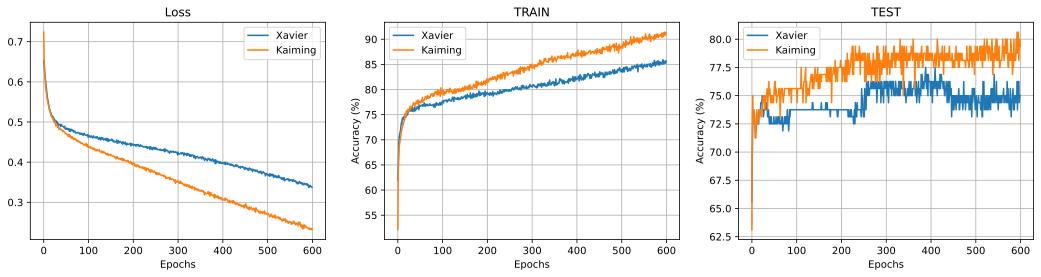

In [10]:
# Plot the results
fig, ax = plt.subplots(1, 3, figsize=(18, 4))

# Losses
ax[0].plot(losses_X, label='Xavier')
ax[0].plot(losses_K, label='Kaiming')
ax[0].set_title('Loss')

# Train accuracy
ax[1].plot(train_acc_X, label='Xavier')
ax[1].plot(train_acc_K, label='Kaiming')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title('TRAIN')

# Test accuracy
ax[2].plot(test_acc_X, label='Xavier')
ax[2].plot(test_acc_K, label='Kaiming')
ax[2].set_ylabel('Accuracy (%)')
ax[2].set_title('TEST')

for i in range(3):
    ax[i].legend()
    ax[i].grid('on')
    ax[i].set_xlabel('Epochs')

plt.show()

# Repeat the experiment to get more stable results

In [12]:
# Number of experiment iterations
num_exps = 10

""" Dimensions of results
1 - Experiment run
2 - Metric (loss/train/test)
3 - Weight init (X/K)
"""
results = np.zeros((num_exps, 3, 2))

for exp_idx in range(num_exps):
    ## XAVIER
    # Create a model
    wine_net_xavier = ANN_wine()

    # Change the weights (leave biases as Kaiming [default])
    for p in wine_net_xavier.named_parameters():
        if ('weight' in p[0]):
            nn.init.xavier_normal_(p[1].data)

    # Train the model and record its output
    train_acc_X, test_acc_X, losses_X = train_the_model(wine_net=wine_net_xavier)

    ## KAIMING
    # Create a model
    wine_net_kaiming = ANN_wine()

    # Change the weights (leave biases as Kaiming [default])
    for p in wine_net_kaiming.named_parameters():
        if ('weight' in p[0]):
            nn.init.kaiming_uniform_(p[1].data, nonlinearity='relu')

    # Train the model and record its output
    train_acc_K, test_acc_K, losses_K = train_the_model(wine_net=wine_net_kaiming)

    ## Collect the results
    results[exp_idx, 0, 0] = torch.mean(losses_X[-5:]).item()
    results[exp_idx, 0, 1] = torch.mean(losses_K[-5:]).item()

    results[exp_idx, 1, 0] = np.mean(train_acc_X[-5:])
    results[exp_idx, 1, 1] = np.mean(train_acc_K[-5:])

    results[exp_idx, 2, 0] = np.mean(test_acc_X[-5:])
    results[exp_idx, 2, 1] = np.mean(test_acc_K[-5:])

    print(f'Finished run {exp_idx} / {num_exps}')

Finished run 0 / 10
Finished run 1 / 10
Finished run 2 / 10
Finished run 3 / 10
Finished run 4 / 10
Finished run 5 / 10
Finished run 6 / 10
Finished run 7 / 10
Finished run 8 / 10
Finished run 9 / 10


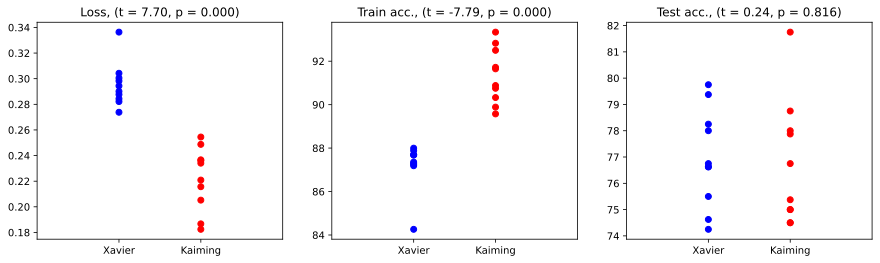

In [14]:
# Plot the results
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

# Plot titles
metric = ['Loss', 'Train acc.', 'Test acc.']

for i in range(3):

    # Plot the results
    ax[i].plot(np.zeros(num_exps), results[:, i, 0], 'bo')
    ax[i].plot(np.ones(num_exps),  results[:, i, 1], 'ro')

    # Run a t-test to formalize the comparison
    t, p = stats.ttest_ind(results[:, i, 0], results[:, i, 1])
    title = f'{metric[i]}, (t = {t:.2f}, p = {p:.3f})'

    # Make the plot nicer
    ax[i].set_xlim([-1, 2])
    ax[i].set_xticks([0, 1])
    ax[i].set_xticklabels(['Xavier', 'Kaiming'])
    ax[i].set_title(title)

plt.show()

# Additional explorations

In [ ]:
# 1) Adam usually works better than SGD with fewer training epochs. Does Adam also equalize the differences attributable
#    to weight initialization?
# 
# 2) The discrepancy between training and test performance suggests that Kaiming initialization involved some overfitting.
#    What are some strategies you could employ to reduce overfitting?
# 
# 3) The difference between X and K initialization is likely to increase with more weights. Change the number of units in
#    the hidden layers from 32 to 64.
# 